In [1]:
# Date: 22-5-2017

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [22]:
# Note: caution: 十一黃金周

df_merged_volume = pd.read_csv("../data/preprocessed_input_traffic_time_and_weather_interpolate_20min_phase1and2_train.csv")

# change "Date" to datetime object
df_merged_volume['date'] = pd.to_datetime(df_merged_volume['date'])

# construct "time of day"
df_merged_volume['timeofday'] = df_merged_volume.date.apply( lambda d : d.hour+d.minute/60.)

In [24]:
# check any unreasonable rows
df_merged_volume.tail(30)

,"('A', 2)","('A', 3)","('B', 1)","('B', 3)","('C', 1)","('C', 3)",date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,dayofweek,is_holiday,timeofday
7027,49.277500,93.632500,121.066667,95.150000,201.725333,158.030000,2016-10-24 14:20:00,14,1010.786550,1015.786550,354.077973,3.349123,20.149123,86.226121,0.0,0,1,14.333333
7028,69.829474,96.445714,133.770000,74.277500,171.234000,125.450000,2016-10-24 14:40:00,14,1010.780117,1015.780117,354.144250,3.350877,20.150877,86.218324,0.0,0,1,14.666667
7029,95.172222,98.460000,123.783750,127.515000,168.852500,183.315000,2016-10-24 15:00:00,15,1010.773684,1015.773684,354.210526,3.352632,20.152632,86.210526,0.0,0,1,15.000000
7030,51.873636,106.870833,104.528000,76.680000,202.636667,144.675000,2016-10-24 15:20:00,15,1010.767251,1015.767251,354.276803,3.354386,20.154386,86.202729,0.0,0,1,15.333333
7031,44.688333,94.068000,102.053333,98.000000,175.865000,203.965000,2016-10-24 15:40:00,15,1010.760819,1015.760819,354.343080,3.356140,20.156140,86.194932,0.0,0,1,15.666667
7032,87.304667,111.742500,140.980000,65.323333,181.693333,159.366667,2016-10-24 16:00:00,16,1010.754386,1015.754386,354.409357,3.357895,20.157895,86.187135,0.0,0,1,16.000000
7033,67.715000,107.980000,111.556000,82.300000,188.636667,159.588333,2016-10-24 16:20:00,16,1010.747953,1015.747953,354.475634,3.359649,20.159649,86.179337,0.0,0,1,16.333333
7034,58.797778,147.760000,121.080000,109.508750,159.583333,159.810000,2016-10-24 16:40:00,16,1010.741520,1015.741520,354.541910,3.361404,20.161404,86.171540,0.0,0,1,16.666667
7035,85.030000,121.974167,114.141667,110.457778,190.150000,161.790000,2016-10-24 17:00:00,17,1010.735088,1015.735088,354.608187,3.363158,20.163158,86.163743,0.0,0,1,17.000000
7036,68.976667,124.404444,128.663333,57.830000,154.650000,165.865000,2016-10-24 17:20:00,17,1010.728655,1015.728655,354.674464,3.364912,20.164912,86.155945,0.0,0,1,17.333333


In [25]:
''' Cut some rows (proprecessing)'''
df_merged_volume = df_merged_volume[4:-1]  # Cut of NaN rows at the beginning, and the last row
df_merged_volume = df_merged_volume.reset_index(drop=True)  # reindexing
df_merged_volume

,"('A', 2)","('A', 3)","('B', 1)","('B', 3)","('C', 1)","('C', 3)",date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,dayofweek,is_holiday,timeofday
0,56.870000,94.570000,176.700000,107.487500,214.870000,119.210588,2016-07-19 01:20:00,1,1000.722222,1005.577778,215.888889,3.522222,29.366667,73.888889,0.0,1,0,1.333333
1,77.740000,88.916667,167.517778,93.720000,160.635000,122.045882,2016-07-19 01:40:00,1,1000.677778,1005.522222,215.111111,3.577778,29.833333,72.111111,0.0,1,0,1.666667
2,60.190000,83.263333,158.335556,67.810000,163.597778,124.881176,2016-07-19 02:00:00,2,1000.633333,1005.466667,214.333333,3.633333,30.300000,70.333333,0.0,1,0,2.000000
3,42.640000,77.610000,149.153333,117.677500,166.560556,127.716471,2016-07-19 02:20:00,2,1000.588889,1005.411111,213.555556,3.688889,30.766667,68.555556,0.0,1,0,2.333333
4,40.173333,85.350000,139.971111,167.545000,169.523333,130.551765,2016-07-19 02:40:00,2,1000.544444,1005.355556,212.777778,3.744444,31.233333,66.777778,0.0,1,0,2.666667
5,41.046667,93.090000,130.788889,144.526667,172.486111,133.387059,2016-07-19 03:00:00,3,1000.500000,1005.300000,212.000000,3.800000,31.700000,65.000000,0.0,1,0,3.000000
6,41.920000,92.794000,121.606667,121.508333,175.448889,136.222353,2016-07-19 03:20:00,3,1000.411111,1005.211111,215.000000,3.588889,31.711111,64.888889,0.0,1,0,3.333333
7,39.430000,92.498000,112.424444,98.490000,178.411667,139.057647,2016-07-19 03:40:00,3,1000.322222,1005.122222,218.000000,3.377778,31.722222,64.777778,0.0,1,0,3.666667
8,48.130000,92.202000,103.242222,96.670000,181.374444,141.892941,2016-07-19 04:00:00,4,1000.233333,1005.033333,221.000000,3.166667,31.733333,64.666667,0.0,1,0,4.000000
9,62.106667,91.906000,94.060000,53.150000,184.337222,144.728235,2016-07-19 04:20:00,4,1000.144444,1004.944444,224.000000,2.955556,31.744444,64.555556,0.0,1,0,4.333333


In [26]:
# Check all the columns

for idx, i in enumerate(df_merged_volume.columns):
    print(idx, i)

0 ('A', 2)
1 ('A', 3)
2 ('B', 1)
3 ('B', 3)
4 ('C', 1)
5 ('C', 3)
6 date
7 hour
8 pressure
9 sea_pressure
10 wind_direction
11 wind_speed
12 temperature
13 rel_humidity
14 precipitation
15 dayofweek
16 is_holiday
17 timeofday


In [27]:
''' Make the dataset stationary '''

station_cols = 6  # select the first 6 columns for stationary

df_merged_volume_copy = df_merged_volume.copy()

for i in range(1, len(df_merged_volume_copy)):
    df_merged_volume_copy.loc[i, df_merged_volume_copy.columns[0:station_cols]] = df_merged_volume.loc[i, df_merged_volume.columns[0:station_cols]] - df_merged_volume.loc[i-1, df_merged_volume.columns[0:station_cols]]

In [29]:
# Check Stationary dataframe

df_merged_volume_copy

,"('A', 2)","('A', 3)","('B', 1)","('B', 3)","('C', 1)","('C', 3)",date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,dayofweek,is_holiday,timeofday
0,56.870000,94.570000,176.700000,107.487500,214.870000,119.210588,2016-07-19 01:20:00,1,1000.722222,1005.577778,215.888889,3.522222,29.366667,73.888889,0.0,1,0,1.333333
1,20.870000,-5.653333,-9.182222,-13.767500,-54.235000,2.835294,2016-07-19 01:40:00,1,1000.677778,1005.522222,215.111111,3.577778,29.833333,72.111111,0.0,1,0,1.666667
2,-17.550000,-5.653333,-9.182222,-25.910000,2.962778,2.835294,2016-07-19 02:00:00,2,1000.633333,1005.466667,214.333333,3.633333,30.300000,70.333333,0.0,1,0,2.000000
3,-17.550000,-5.653333,-9.182222,49.867500,2.962778,2.835294,2016-07-19 02:20:00,2,1000.588889,1005.411111,213.555556,3.688889,30.766667,68.555556,0.0,1,0,2.333333
4,-2.466667,7.740000,-9.182222,49.867500,2.962778,2.835294,2016-07-19 02:40:00,2,1000.544444,1005.355556,212.777778,3.744444,31.233333,66.777778,0.0,1,0,2.666667
5,0.873333,7.740000,-9.182222,-23.018333,2.962778,2.835294,2016-07-19 03:00:00,3,1000.500000,1005.300000,212.000000,3.800000,31.700000,65.000000,0.0,1,0,3.000000
6,0.873333,-0.296000,-9.182222,-23.018333,2.962778,2.835294,2016-07-19 03:20:00,3,1000.411111,1005.211111,215.000000,3.588889,31.711111,64.888889,0.0,1,0,3.333333
7,-2.490000,-0.296000,-9.182222,-23.018333,2.962778,2.835294,2016-07-19 03:40:00,3,1000.322222,1005.122222,218.000000,3.377778,31.722222,64.777778,0.0,1,0,3.666667
8,8.700000,-0.296000,-9.182222,-1.820000,2.962778,2.835294,2016-07-19 04:00:00,4,1000.233333,1005.033333,221.000000,3.166667,31.733333,64.666667,0.0,1,0,4.000000
9,13.976667,-0.296000,-9.182222,-43.520000,2.962778,2.835294,2016-07-19 04:20:00,4,1000.144444,1004.944444,224.000000,2.955556,31.744444,64.555556,0.0,1,0,4.333333


In [30]:
## Hidden the selecting time
# select the time for training: 6:20-10:00 (5 + 6 timestamp) and 15:20-19:00 (5 + 6 timestamp)
# sel_rows = df_merged_volume_copy[ ((df_merged_volume_copy.timeofday>= 6.3) & (df_merged_volume_copy.timeofday<10)) |
#                             ((df_merged_volume_copy.timeofday>=15.3) & (df_merged_volume_copy.timeofday<19))]

## This time, training all time (24hrs) except the first non-stationary row
sel_rows = df_merged_volume_copy[1:]

In [32]:
# select using columns

using_cols = [
#                 "(1, 0, 'cargocar')",
#                 "(1, 0, 'etc')",
#                 "(1, 0, 'motorcycle')",
#                 "(1, 0, 'privatecar')",
#                 "(1, 0, 'tot')",
#                 "(1, 0, 'unknowncar')",
#                 "(1, 1, 'cargocar')",
#                 "(1, 1, 'etc')",
#                 "(1, 1, 'motorcycle')",
#                 "(1, 1, 'privatecar')",
#                 "(1, 1, 'tot')",
#                 "(1, 1, 'unknowncar')",
#                 "(2, 0, 'cargocar')",
#                 "(2, 0, 'etc')",
#                 "(2, 0, 'motorcycle')",
#                 "(2, 0, 'privatecar')",
#                 "(2, 0, 'tot')",
#                 "(2, 0, 'unknowncar')",
#                 "(3, 0, 'cargocar')",
#                 "(3, 0, 'etc')",
#                 "(3, 0, 'motorcycle')",
#                 "(3, 0, 'privatecar')",
#                 "(3, 0, 'tot')",
#                 "(3, 0, 'unknowncar')",
#                 "(3, 1, 'cargocar')",
#                 "(3, 1, 'etc')",
#                 "(3, 1, 'motorcycle')",
#                 "(3, 1, 'privatecar')",
#                 "(3, 1, 'tot')",
#                 "(3, 1, 'unknowncar')",
                "('A', 2)",
#                 "('A', 3)",
#                 "('B', 1)",
#                 "('B', 3)",
#                 "('C', 1)",
#                 "('C', 3)",
#                 'date',  # <== Notice this
                'hour',
                'pressure',
                'sea_pressure',
                'wind_direction',
                'wind_speed',
                'temperature',
                'rel_humidity',
                'precipitation',
                'dayofweek',
                'is_holiday',
                'timeofday'
              ]

sel_rows = sel_rows[using_cols]

In [33]:
# split to train and valid set
train_rows = sel_rows[: -24*3*7]
valid_rows = sel_rows[-24*3*7:] # reserve 7 days for validation

# get numpy array from panda dataframe
train_arr = train_rows.values
valid_arr = valid_rows.values

# np.shape(train_arr)
# Out:
# (726, 17)

In [34]:
#scale feature array to range -1 to 1

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_arr)
train_scaled_arr = scaler.transform(train_arr)

valid_scaled_arr = scaler.transform(valid_arr)

In [35]:
# sample subsequence from the time series
train_seqs = []
len_seqs = len(train_scaled_arr) - 6 + 1  # 6 is window size
for i in range(len_seqs):
    train_seqs.append(train_scaled_arr[i: i+6])  # append 6 timestamps each time (5 timestamps for x, 1 timestamp for y)
train_seqs = np.stack(train_seqs)

valid_seqs = []
len_v_seqs = len(valid_scaled_arr) - 6 + 1  # 6 is window size
for i in range(len_v_seqs):
    valid_seqs.append(valid_scaled_arr[i: i+6])
valid_seqs = np.stack(valid_seqs)

In [37]:
# checking
train_seqs[:,:,:].shape

(6542, 6, 12)

In [38]:
#keras
#https://keras.io/getting-started/sequential-model-guide/#examples
input_dim = len(using_cols)  # The features
output_dim = 1  # 
timesteps = 5 # use 5 timesteps to predict the 6th

x_train, y_train = train_seqs[:, 0:-1], train_seqs[:, -1, 0:output_dim]  # 0:output_dim is for deciding the output features
x_valid , y_valid  =  valid_seqs[:, 0:-1],  valid_seqs[:, -1, 0:output_dim]  # 0:output_dim is for deciding the output features

In [39]:
y_train.shape

(6542, 1)

In [40]:
num_epochs = 200
loss_fuc = 'mean_squared_error'

# construct the callback
filepath="best_epoch_T.M._A-2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model = Sequential()
model.add(LSTM(128, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(LSTM(128))
model.add(Dense(output_dim))
model.compile(loss=loss_fuc, optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 128)            72192     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 203,905
Trainable params: 203,905
Non-trainable params: 0
_________________________________________________________________
Train on 6542 samples, validate on 499 samples
Epoch 1/200
6542/6542 [==============================] - 7s - loss: 0.0053 - val_loss: 0.0033
Epoch 2/200
6542/6542 [==============================] - 5s - loss: 0.0032 - val_loss: 0.0031
Epoch 3/200
6542/6542 [==============================] - 5s - loss: 0.0032 - val_loss: 0.0031
Epoch 4/200
6542/6542 [==============================] - 6s - loss: 0.0

6542/6542 [==============================] - 6s - loss: 0.0022 - val_loss: 0.0020
Epoch 34/200
6542/6542 [==============================] - 6s - loss: 0.0022 - val_loss: 0.0018
Epoch 35/200
6542/6542 [==============================] - 6s - loss: 0.0022 - val_loss: 0.0021
Epoch 36/200
6542/6542 [==============================] - 6s - loss: 0.0022 - val_loss: 0.0018
Epoch 37/200
6542/6542 [==============================] - 6s - loss: 0.0022 - val_loss: 0.0018
Epoch 38/200
6542/6542 [==============================] - 6s - loss: 0.0021 - val_loss: 0.0019
Epoch 39/200
6542/6542 [==============================] - 6s - loss: 0.0022 - val_loss: 0.0018
Epoch 40/200
6542/6542 [==============================] - 6s - loss: 0.0021 - val_loss: 0.0018
Epoch 41/200
6542/6542 [==============================] - 6s - loss: 0.0021 - val_loss: 0.0018
Epoch 42/200
6542/6542 [==============================] - 6s - loss: 0.0021 - val_loss: 0.0018
Epoch 43/200
6542/6542 [==============================] - 6s - 

6542/6542 [==============================] - 7s - loss: 0.0020 - val_loss: 0.0021
Epoch 73/200
6542/6542 [==============================] - 7s - loss: 0.0020 - val_loss: 0.0019
Epoch 74/200
6542/6542 [==============================] - 6s - loss: 0.0020 - val_loss: 0.0018
Epoch 75/200
6542/6542 [==============================] - 8s - loss: 0.0020 - val_loss: 0.0018
Epoch 76/200
6542/6542 [==============================] - 7s - loss: 0.0020 - val_loss: 0.0018
Epoch 77/200
6542/6542 [==============================] - 7s - loss: 0.0019 - val_loss: 0.0018
Epoch 78/200
6542/6542 [==============================] - 7s - loss: 0.0020 - val_loss: 0.0019
Epoch 79/200
6542/6542 [==============================] - 7s - loss: 0.0019 - val_loss: 0.0018
Epoch 80/200
6542/6542 [==============================] - 7s - loss: 0.0018 - val_loss: 0.0018
Epoch 81/200
6542/6542 [==============================] - 6s - loss: 0.0017 - val_loss: 0.0018
Epoch 82/200
6542/6542 [==============================] - 6s - 

6542/6542 [==============================] - 6s - loss: 0.0016 - val_loss: 0.0017
Epoch 113/200
6542/6542 [==============================] - 6s - loss: 0.0016 - val_loss: 0.0018
Epoch 114/200
6542/6542 [==============================] - 6s - loss: 0.0016 - val_loss: 0.0020
Epoch 115/200
6542/6542 [==============================] - 6s - loss: 0.0016 - val_loss: 0.0018
Epoch 116/200
6542/6542 [==============================] - 6s - loss: 0.0016 - val_loss: 0.0018
Epoch 117/200
6542/6542 [==============================] - 6s - loss: 0.0016 - val_loss: 0.0018
Epoch 118/200
6542/6542 [==============================] - 6s - loss: 0.0016 - val_loss: 0.0018
Epoch 119/200
6542/6542 [==============================] - 6s - loss: 0.0016 - val_loss: 0.0018
Epoch 120/200
6542/6542 [==============================] - 6s - loss: 0.0016 - val_loss: 0.0018
Epoch 121/200
6542/6542 [==============================] - 6s - loss: 0.0016 - val_loss: 0.0018
Epoch 122/200
6542/6542 [=============================

6542/6542 [==============================] - 6s - loss: 0.0014 - val_loss: 0.0018
Epoch 153/200
6542/6542 [==============================] - 6s - loss: 0.0014 - val_loss: 0.0018
Epoch 154/200
6542/6542 [==============================] - 6s - loss: 0.0014 - val_loss: 0.0018
Epoch 155/200
6542/6542 [==============================] - 6s - loss: 0.0015 - val_loss: 0.0018
Epoch 156/200
6542/6542 [==============================] - 6s - loss: 0.0014 - val_loss: 0.0018
Epoch 157/200
6542/6542 [==============================] - 6s - loss: 0.0014 - val_loss: 0.0018
Epoch 158/200
6542/6542 [==============================] - 6s - loss: 0.0015 - val_loss: 0.0018
Epoch 159/200
6542/6542 [==============================] - 6s - loss: 0.0014 - val_loss: 0.0019
Epoch 160/200
6542/6542 [==============================] - 6s - loss: 0.0014 - val_loss: 0.0018
Epoch 161/200
6542/6542 [==============================] - 6s - loss: 0.0014 - val_loss: 0.0019
Epoch 162/200
6542/6542 [=============================

6542/6542 [==============================] - 6s - loss: 0.0012 - val_loss: 0.0019
Epoch 194/200
6542/6542 [==============================] - 6s - loss: 0.0012 - val_loss: 0.0020
Epoch 195/200
6542/6542 [==============================] - 6s - loss: 0.0012 - val_loss: 0.0019
Epoch 196/200
6542/6542 [==============================] - 6s - loss: 0.0012 - val_loss: 0.0020
Epoch 197/200
6542/6542 [==============================] - 6s - loss: 0.0012 - val_loss: 0.0019
Epoch 198/200
6542/6542 [==============================] - 6s - loss: 0.0012 - val_loss: 0.0022
Epoch 199/200
6542/6542 [==============================] - 6s - loss: 0.0012 - val_loss: 0.0019
Epoch 200/200
6542/6542 [==============================] - 6s - loss: 0.0012 - val_loss: 0.0019


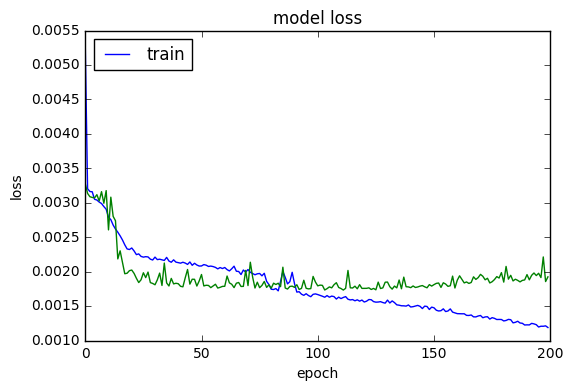

In [41]:
## Start Training
model.summary()
history_w_model = model.fit(x_train, y_train, callbacks=callbacks_list, epochs=num_epochs, batch_size=64, validation_data=(x_valid, y_valid))

plt.plot(history_w_model.history['loss'], label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.plot(history_w_model.history['val_loss'], label='Val_loss')
plt.show()

In [1]:
# load weights into the model
model.load_weights("best_epoch.hdf5")
print("Loaded model from disk")

model.compile(loss='mean_squared_error', optimizer='adam')

NameError: name 'model' is not defined

In [322]:
''' === Prediction ===
Procedure:
1. Load CSV
2. to_datetime
3. create timeofday column
4. select the time for training: 6:00-8:00 (6 timestamps) and 15:00-17:00 (6 timestamps)
5. change it to stationary
6. Use using_cols to select the features
7. change to np array
8. MinMaxScaler
9. make the sequences tensor as input
10. make a forloop for prediction

'''
# 1. Load CSV - Vol + Route + Weather (Only Weather is 24-hour data)
df_pred = pd.read_csv('../data/preprocessed_input_interpolate_20min_phase2_test.csv')

# 2. to_datetime
df_pred['date'] = pd.to_datetime(df_pred['date'])

# 3. create timeofday column
df_pred['timeofday'] = df_pred.date.apply( lambda d : d.hour+d.minute/60.)

# 4. select the time for training

df_pred_sel_time = df_pred[ ((df_merged_volume_copy.timeofday>= 6) & (df_merged_volume_copy.timeofday<8)) |
                            ((df_merged_volume_copy.timeofday>=15) & (df_merged_volume_copy.timeofday<17))]

df_feedin_weather_sel_time = df_pred[ ((df_merged_volume_copy.timeofday>= 8) & (df_merged_volume_copy.timeofday<10)) |
                            ((df_merged_volume_copy.timeofday>=17) & (df_merged_volume_copy.timeofday<19))]

# 5. change it to stationary
df_pred_sel_time = df_pred_sel_time.reset_index(drop=True)

df_pred_sel_time_copy = df_pred_sel_time.copy()



for i in range(len(df_pred_sel_time_copy)//6):  # make the loop for 14 time slots (2 different time slot x 7days)
    for t in range(5):  #  Do the "difference" 5 times every loop
        start_idx = i*6 + t + 1  # Add 1 is for starting it from index 1 in every 6-space time slot
        df_pred_sel_time_copy.loc[start_idx, df_pred_sel_time_copy.columns[0:36]] = df_pred_sel_time.loc[start_idx, df_pred_sel_time.columns[0:36]] - df_pred_sel_time.loc[start_idx-1, df_pred_sel_time.columns[0:36]]

# 6. Use using_cols to select the features
sel_rows_pred = df_pred_sel_time_copy[ using_cols ]

sel_rows_feedin_weather = df_feedin_weather_sel_time[using_cols[3:]]

# 7. change to np array
pred_arr = sel_rows_pred.values

feedin_weather_arr = sel_rows_feedin_weather.values

# 8. MinMaxScaler
pred_arr_scaled = scaler.transform(pred_arr)

# add some dummy cells in front of the weather_array for transform
temp_arr = np.zeros((84,3))
feedin_weather_arr = np.concatenate([temp_arr, feedin_weather_arr], axis=1)

feedin_weather_arr_scaled = scaler.transform(feedin_weather_arr)

# Now pred_arr_scaled is (84 x 17)

/Users/Kin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/Kin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [323]:
# 9. make the sequences tensor as input
# Put into the model to get the prediction

ans_arr = []  # For holding the output answer
    
for i in range(len(pred_arr_scaled)//6):  # make the loop for 14 time slots (2 different time slot x 7days)
    # creating pre_seq
    pred_seq = []
    for t in range(5):  #  Do the "difference" 5 times every loop
        k = i*6 + t + 1  # Add 1 is for starting it from index 1 in every 6-space time slot, to ignore the first index which is non-stationary
        pred_seq.append(pred_arr_scaled[k])  # creating a sequence for a time slot
    
    # creating feedin_weather_seq
    feedin_weather_seq = []
    for t in range(6):  #  Do 6 times every loop
        k = i*6 + t  #
        feedin_weather_seq.append(feedin_weather_arr_scaled[k])


    pred_seq = np.stack(pred_seq)  # change back to the numpy array (2D)
    pred_seq = pred_seq.reshape(1, pred_seq.shape[0], pred_seq.shape[1])  # change to numpy 3D as input

    feedin_weather_seq = np.stack(feedin_weather_seq)  # change back to the numpy array (2D)
    feedin_weather_seq = feedin_weather_seq.reshape(1, feedin_weather_seq.shape[0], feedin_weather_seq.shape[1])  # change to numpy 3D as input

    for q in range(6):
        # predict next timestamp
        output_pred = model.predict(pred_seq)  # get one prediction output (size (1 x 3))
        ans_arr.append(output_pred)

        # update the input seq
        for j in range(1,5):
            pred_seq[0][j-1] = pred_seq[0][j]
        pred_seq[0][4] = feedin_weather_seq[0][q]
        pred_seq[0][4][0:3] = output_pred[0]

In [314]:
# 10. Backward to the non-stationary, correct scale output

#  Helper functions

def backward_scaler(nn_output):
    tmp = np.zeros(14)
    tmp[0:3] = nn_output
    tmp = scaler.inverse_transform(tmp)
    return tmp[0:3]

def decode(last_timestamp_values, nn_output):
    tmp = np.zeros(14)
    tmp[0:3] = nn_output
    tmp = scaler.inverse_transform(tmp)
    return last_timestamp_values + tmp[0:3]

# create the non-stationary 6:40 and 16:40 for decoding
df_non_station_sel_time = df_pred[ ((df_merged_volume_copy.timeofday>= 7.5) & (df_merged_volume_copy.timeofday<8)) |
                            ((df_merged_volume_copy.timeofday>=16.5) & (df_merged_volume_copy.timeofday<17))]

''' Output the non-stationary Answers (allAns)'''

tmp = df_non_station_sel_time[using_cols[0:3]].values
allAns = []
for i in range(len(tmp)):
    seed = tmp[i]  # non-stationary for reconstructing a sequence
    segmentAns = []
    for timestep in range(6):
        seed = decode(seed, ans_arr[i*6+timestep])
        segmentAns.append(seed)
    allAns.append(segmentAns)

# Change back to np array for easy visualize
allAns = np.array(allAns)


In [329]:
# Checking
for i in allAns:
    print(i)

[[  36.52179618  115.11936277   83.89482761]
 [  37.79215259  102.33503303   84.94230892]
 [  38.05784869  101.9343416    79.10011784]
 [  23.66506636   76.6362073    56.65154649]
 [  16.97176268   58.61350447   45.14071977]
 [  18.44870608   55.48907958   37.17015323]]
[[ 24.45008612  64.95174107  56.3886976 ]
 [ 25.13072504  56.58128543  51.37222254]
 [ 27.04738815  48.22112541  35.40873492]
 [ 28.58971331  39.00137533  26.08068621]
 [ 30.84038023  29.09387629  14.77572424]
 [ 31.81641516  17.43871207   5.51338926]]
[[  39.14359605  111.45953527   87.43406213]
 [  31.96291944  109.65849826   86.55524226]
 [  29.45581917  106.04594712   93.10835795]
 [  32.74891879  111.95764956   93.82222541]
 [  26.9057316   101.91378407   95.29282598]
 [  18.30361511   81.4291492    96.9114671 ]]
[[ 23.17315727  80.6472937   57.24725467]
 [ 23.15143036  76.70620048  69.74401346]
 [ 24.26964075  73.30315528  63.85254783]
 [ 22.37687289  64.6389973   68.39513478]
 [ 23.01884486  61.82683048  67.65033

In [364]:
# 11. Output the CSV file

# create the datetime objects
import datetime

start_8am = datetime.datetime(year=2016, month=10, day=25, hour=8, minute=0, second=0)
start_5pm = datetime.datetime(year=2016, month=10, day=25, hour=17, minute=0, second=0)
add_1_day = datetime.timedelta(days=1)
add_20_min = datetime.timedelta(minutes=20)

'''
allAns[x,y,z]
[x]: Segment (AM & PM, total 14)
[y]: timestamp (6 [20mins])
[z]: 3 features
'''
# allAns[0,:,1]

checkpoint = '2'
direction = '0'
vol_or_traj = 1

with open('{}-{}.csv'.format(checkpoint, direction), 'w') as f:
    for day in range(7):
        for am_pm in range(2):
            if am_pm == 0:
                ref_time = start_8am
            else:
                ref_time = start_5pm
            for timestep in range(6):
                start_timestamp = ref_time + day*add_1_day + timestep*add_20_min
                end_timestamp = start_timestamp + add_20_min
                start_timestr = start_timestamp.strftime("%Y-%m-%d %H:%M:00")
                end_timestr = end_timestamp.strftime("%Y-%m-%d %H:%M:00")
                f.write('{},"[{},{})",{},{}\n'.format(checkpoint,
                                                  start_timestr,
                                                  end_timestr,
                                                  direction,
                                                  allAns[day*2+am_pm, timestep, vol_or_traj ]))




